In [624]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import spearmanr

from tensorflow import keras
from keras import layers

import CCLE_utils
import MMRF_utils

In [130]:
data_dir = '/Users/nalinisingh/datasets/depmap/'
mmrf_rna_dir = '/Users/nalinisingh/datasets/multiple_myeloma/MMRF_CoMMpass_IA15a_E74GTF_Cufflinks_Gene_FPKM.txt'
rna_map_path = 'Ensembl_HGNC_map_042421.csv'

## Load CCLE Data

In [651]:
CCLE_utils.get_ccle_rnaseq_with_ensembl(os.path.join(data_dir,'CCLE_expression.csv'), rna_map_path)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000185097,ENSG00000204293,ENSG00000187600,ENSG00000197376,ENSG00000235249,ENSG00000116957,ENSG00000227135,ENSG00000145075,ENSG00000187951,ENSG00000168255
0,4.990501,0.000000,7.273702,2.765535,4.480265,0.028569,1.269033,3.058316,6.483171,5.053980,...,0.070389,0.0,0.0,0.0,0.070389,5.761019,0.0,0.028569,1.214125,5.781884
1,5.209843,0.545968,7.070604,2.538538,3.510962,0.000000,0.176323,3.836934,4.200850,3.832890,...,0.014355,0.0,0.0,0.0,0.014355,5.771357,0.0,1.090853,1.835924,4.704319
2,3.779260,0.000000,7.346425,2.339137,4.254745,0.056584,1.339137,6.724241,3.671293,3.775051,...,0.014355,0.0,0.0,0.0,0.014355,4.744699,0.0,0.000000,1.823749,4.931683
3,5.726831,0.000000,7.086189,2.543496,3.102658,0.000000,5.914565,6.099716,4.475733,4.294253,...,0.000000,0.0,0.0,0.0,0.000000,4.164304,0.0,0.000000,0.871844,3.858976
4,7.465648,0.000000,6.435462,2.414136,3.864929,0.831877,7.198003,5.452530,7.112492,4.710944,...,0.014355,0.0,0.0,0.0,0.014355,4.673556,0.0,0.000000,2.324811,4.990501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,4.173127,0.000000,6.400879,1.807355,3.303050,0.014355,0.137504,4.944858,4.528571,4.383359,...,0.000000,0.0,0.0,0.0,0.000000,4.513491,0.0,0.014355,1.280956,5.102658
1372,0.097611,0.000000,6.428276,3.257011,4.980482,0.411426,0.124328,0.704872,4.829342,5.393348,...,0.014355,0.0,0.0,0.0,0.014355,5.553361,0.0,0.014355,2.939227,6.341630
1373,5.045268,0.000000,6.991749,1.807355,3.270529,0.028569,3.333424,6.819796,5.395063,3.727920,...,0.070389,0.0,0.0,0.0,0.070389,4.887525,0.0,0.014355,1.510962,4.607626
1374,5.805292,0.000000,7.792855,2.482848,3.903038,0.028569,4.124328,6.816600,4.458119,3.664483,...,0.084064,0.0,0.0,0.0,0.084064,4.040016,0.0,0.137504,0.757023,4.787119


In [652]:
ccle = pd.read_csv(os.path.join(data_dir,'CCLE_expression.csv'))

In [653]:
ccle = ccle.sample(frac=1).reset_index(drop=True)

In [654]:
rna_map = pd.read_csv(rna_map_path)
rna_map_dict = {}
for _, row in rna_map.iterrows():
    rna_map_dict[row['HGNC_ID']] = row['Ensembl_ID']

In [655]:
def hgnc_to_ensembl(hgnc_df):
    to_del = []
    for col in hgnc_df:
        if(col not in rna_map_dict):
            to_del.append(col)
            
    hgnc_df.drop(columns=to_del, inplace=True)
    
    ensembl_df = hgnc_df.rename(columns=rna_map_dict)
    return ensembl_df

In [656]:
ccle_ensembl = hgnc_to_ensembl(ccle)

In [657]:
np.random.seed(0)
n_points = ccle_ensembl.shape[0]

n_train = int(n_points*0.7)
n_val = int(n_points*0.1)
n_test = n_points-(n_train+n_val)

train_ccle = ccle_ensembl.loc[:n_train,:].values
val_ccle = ccle_ensembl.loc[n_train:n_train+n_val,:].values
test_ccle = ccle_ensembl.loc[n_train+n_val:,:].values

In [658]:
n_components = 500
ccle_pca = PCA(n_components = n_components)
ccle_pca.fit(train_rna)

train_ccle_pca = ccle_pca.transform(train_ccle)
val_ccle_pca = pca.transform(val_ccle)
test_ccle_pca = pca.transform(test_ccle)

# Load MMRF Data

In [803]:
train_patient_all = pd.DataFrame()
valid_patient_all = pd.DataFrame()
test_patient_all = pd.DataFrame()

for ind in [1]:
    data_filename = '/Users/nalinisingh/dev/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_pfs_ind_seed0.pkl'#%(ind)
    train, test, valid = MMRF_utils.get_train_test_valid(data_filename, ind, show_features=True)

    print('\nPreprocess patient data in MMRF')
    # include the first n clinical visit data for each patient (default 0)
    train_df = MMRF_utils.preprocess_patient_data(train, num_clin_visits=3)  
    print(train_df.shape)

    valid_df = MMRF_utils.preprocess_patient_data(valid, num_clin_visits=3)  
    print(valid_df.shape)

    test_df = MMRF_utils.preprocess_patient_data(test, num_clin_visits=3)  
    print(test_df.shape)

    print('\nPreprocess patient genomic data in MMRF...')
    genomic_fn = '/Users/nalinisingh/datasets/multiple_myeloma/MMRF_CoMMpass_IA15a_E74GTF_Salmon_Gene_TPM.txt'
    genomic_df = MMRF_utils.preprocess_genomic_data(genomic_fn, nPCA=0)
    print(genomic_df.shape)

    print('\nMerging patient data with genomic data...')
    train_patient_all = train_patient_genomic.append(train_df.merge(genomic_df, left_on='pids', right_on='pids'))

    valid_patient_all = valid_patient_genomic.append(valid_df.merge(genomic_df, left_on='pids', right_on='pids'))

    test_patient_all = test_patient_genomic.append(test_df.merge(genomic_df, left_on='pids', right_on='pids'))
    



loading from: /Users/nalinisingh/dev/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos_pfs_ind_seed0.pkl
pids
(494,)
x
(494, 33, 16)
m
(494, 33, 16)
feature_names_x
(16,)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
ys_seq
(494, 1)
ce
(494, 1)
feature_names_y
(1,)
['progression free survival (all)']
b
(494, 16)
feature_names
(16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
a
(494, 33, 9)
m_a
(494, 33, 6)
feature_names_a
(9,)
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']

Preprocess patient data in MMRF
Keep first 3 clinical visits.
(494, 93)
Keep first 3 clinical visits.
(200, 93)
Keep first 3 clinical vi

In [800]:
train_pfs = train_patient_all['pfs']
valid_pfs = valid_patient_all['pfs']
test_pfs = test_patient_all['pfs']

In [771]:
bor_train_patient_all = train_patient_all[train_patient_all['Bor1']==True]
bor_valid_patient_all = valid_patient_all[valid_patient_all['Bor1']==True]
bor_test_patient_all = test_patient_all[test_patient_all['Bor1']==True]

bor_train_pfs = bor_train_patient_all['pfs']
bor_valid_pfs = bor_valid_patient_all['pfs']
bor_test_pfs = bor_test_patient_all['pfs']

In [772]:
def drop_unnecessary_cols(genomic_df):
    to_del = []
    for col in genomic_df:
        if(col not in cell_line_ensembl.columns):
            to_del.append(col)
            
    genomic_df.drop(columns=to_del, inplace=True)

bor_train_patient_all_mat = bor_train_patient_genomic.values[:,2:]
bor_valid_patient_all_mat = bor_valid_patient_genomic.values[:,2:]
bor_test_patient_all_mat = bor_test_patient_genomic.values[:,2:]

drop_unnecessary_cols(train_patient_genomic)
drop_unnecessary_cols(valid_patient_genomic)
drop_unnecessary_cols(test_patient_genomic)

train_patient_genomic = train_patient_all[ccle_ensembl.columns]
valid_patient_genomic = valid_patient_all[ccle_ensembl.columns]
test_patient_genomic = test_patient_all[ccle_ensembl.columns]

bor_train_patient_genomic = bor_train_patient_all[cell_line_ensembl.columns]
bor_valid_patient_genomic = bor_valid_patient_all[cell_line_ensembl.columns]
bor_test_patient_genomic = bor_test_patient_all[cell_line_ensembl.columns]

def drop_ensembl_cols(df):
    to_keep = []
    for col in df.columns:
        if((col not in cell_line_ensembl.columns) and (col not in ['pfs','pids']) and ('ERCC' not in col) and ('ENSG' not in col)):
            to_keep.append(col)
            
    return df[to_keep]
            
train_patient_meddata = drop_ensembl_cols(train_patient_all)
valid_patient_meddata = drop_ensembl_cols(valid_patient_all)
test_patient_meddata = drop_ensembl_cols(test_patient_all)

bor_train_patient_meddata = drop_ensembl_cols(bor_train_patient_all)
bor_valid_patient_meddata = drop_ensembl_cols(bor_valid_patient_all)
bor_test_patient_meddata = drop_ensembl_cols(bor_test_patient_all)


/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [777]:
assert((ccle_ensembl.columns==train_patient_genomic.columns).all())

## Autoencoder

In [778]:
def get_autoencoder(encoding_dim):
    out_shape = train_patient_genomic.shape[1]
    # This is our input image
    input_rna = keras.Input(shape=(out_shape,))

    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(4*encoding_dim, activation='relu')(input_rna)
    encoded = layers.Dense(2*encoding_dim, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation=None)(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(4*encoding_dim, activation='relu')(encoded)                                                          
    decoded = layers.Dense(2*encoding_dim, activation='relu')(decoded)
    decoded = layers.Dense(out_shape, activation=None)(decoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_rna, decoded)
    autoencoder.compile(optimizer='adam', loss='MSE')
    
    return autoencoder

In [779]:
mmrf_ae = get_autoencoder(64)
mmrf_ae.fit(train_patient_genomic, train_patient_genomic,
                epochs=300,
                batch_size=64,
                shuffle=True,
                validation_data=(valid_patient_genomic, valid_patient_genomic),
                verbose=0)

In [780]:
bor_ae = get_autoencoder(64)
bor_ae.fit(bor_train_patient_genomic, bor_train_patient_genomic,
                epochs=300,
                batch_size=64,
                shuffle=True,
                validation_data=(bor_valid_patient_genomic, bor_valid_patient_genomic),
                verbose=0)

In [781]:
ccle_ae = get_autoencoder(64)
ccle_ae.fit(train_ccle, train_ccle,
                epochs=600,
                batch_size=64,
                shuffle=True,
                validation_data=(val_ccle, val_ccle),
                verbose=0)

Text(0, 0.5, 'Predicted Component')

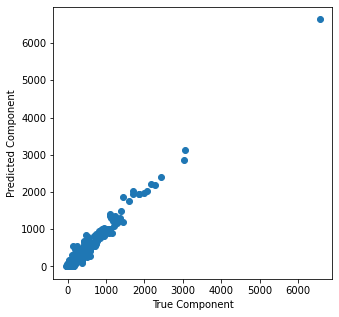

In [782]:
plt.figure(figsize=(5,5))
plt.scatter(mmrf_ae.predict(np.array(valid_patient_genomic)[0:1,:]),np.array(valid_patient_genomic)[0:1,:])
plt.xlabel('True Component')
plt.ylabel('Predicted Component')

## PFS Binary Classifications

In [827]:
def get_stats(true_pfs,pred_pfs):
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    return([np.round(metric(true_pfs, pred_pfs),2) for metric in metrics])

In [853]:
pfs_results_df = pd.DataFrame()
bin_bor_train_pfs = bor_train_pfs>12
bin_bor_valid_pfs = bor_valid_pfs>12

In [854]:
def reg_routine(train_data, train_pfs, val_data, val_pfs, label_str):
    best_val = np.inf
    best_reg = None
    best_alpha = None
    
    for alpha in [1e-3, 1e-2, 0.1, 1]:

        reg = LogisticRegression(penalty='l2', C=alpha, max_iter=3000).fit(train_data, train_pfs)
        accuracy, precision, recall, f1 = get_stats(val_pfs, reg.predict(val_data))

        if(accuracy > best_val):
            best_val = accuracy
            best_reg = reg
            best_alpha = alpha
            
    tr_stats = get_stats(train_pfs, reg.predict(train_data))
    val_stats = get_stats(val_pfs, reg.predict(val_data))
    
    return {'Experiment': label_str,
                          'Train Accuracy': tr_stats[0],
                          'Train Precision': tr_stats[1],
                          'Train Recall': tr_stats[2],
                          'Train F1': tr_stats[3],
                          
                          'Val Accuracy': val_stats[0],
                          'Val Precision': val_stats[1],
                          'Val Recall': val_stats[2],
                          'Val F1': val_stats[3]}


In [855]:
# Raw RNA Seq
results = reg_routine(bor_train_patient_genomic, bin_bor_train_pfs, bor_valid_patient_genomic, bin_bor_valid_pfs, 'MMRF RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


In [856]:
# Raw Labs
results = reg_routine(bor_train_patient_meddata, bin_bor_train_pfs, bor_valid_patient_meddata, bin_bor_valid_pfs, 'MMRF Labs')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)

In [857]:
# RNA Seq + Labs
tr_compiled = np.concatenate((bor_train_patient_meddata, bor_train_patient_genomic), axis=1)
val_compiled = np.concatenate((bor_valid_patient_meddata, bor_valid_patient_genomic), axis=1)
results = reg_routine(tr_compiled, bin_bor_train_pfs, val_compiled, bin_bor_valid_pfs, 'MMRF RNA Seq + Labs')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)

In [858]:
def mmrf_ae_encode(rna_data):
    encoder = keras.Model(inputs=mmrf_ae.input, outputs=mmrf_ae.layers[2].output)
    return(encoder(rna_data))

def bor_ae_encode(rna_data):
    encoder = keras.Model(inputs=bor_ae.input, outputs=bor_ae.layers[2].output)
    return(encoder(rna_data))

In [859]:
bor_mmrfae_train = mmrf_ae_encode(bor_train_patient_genomic.values)
bor_mmrfae_valid = mmrf_ae_encode(bor_valid_patient_genomic.values)

bor_borae_train = bor_ae_encode(bor_train_patient_genomic.values)
bor_borae_valid = bor_ae_encode(bor_valid_patient_genomic.values)

In [860]:
# MMRF Autoencoded RNA Seq
results = reg_routine(bor_mmrfae_train, bin_bor_train_pfs, bor_mmrfae_valid, bin_bor_valid_pfs, 'MMRF AE RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [861]:
# MMRF Autoencoded RNA Seq + Labs
tr_compiled = np.concatenate((bor_train_patient_meddata, bor_mmrfae_train), axis=1)
val_compiled = np.concatenate((bor_valid_patient_meddata, bor_mmrfae_valid), axis=1)
results = reg_routine(tr_compiled, bin_bor_train_pfs, val_compiled, bin_bor_valid_pfs, 'MMRF AE RNA Seq + Labs')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [862]:
# MMRF Bortezomib Autoencoded RNA Seq
results = reg_routine(bor_borae_train, bin_bor_train_pfs, bor_borae_valid, bin_bor_valid_pfs, 'Bor AE RNA Seq')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [863]:
# MMRF Autoencoded RNA Seq + Labs
tr_compiled = np.concatenate((bor_train_patient_meddata, bor_borae_train), axis=1)
val_compiled = np.concatenate((bor_valid_patient_meddata, bor_borae_valid), axis=1)
results = reg_routine(tr_compiled, bin_bor_train_pfs, val_compiled, bin_bor_valid_pfs, 'Bor AE RNA Seq + Labs')
pfs_results_df = pfs_results_df.append(results, ignore_index=True)


/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nalinisingh/anaconda3/envs/mm_disease_prog/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [864]:
pfs_results_df

,Experiment,Train Accuracy,Train F1,Train Precision,Train Recall,Val Accuracy,Val F1,Val Precision,Val Recall
0,MMRF RNA Seq,1.00,1.00,1.00,1.00,0.57,0.62,0.65,0.60
1,MMRF Labs,0.80,0.85,0.80,0.90,0.56,0.66,0.60,0.73
2,MMRF RNA Seq + Labs,1.00,1.00,1.00,1.00,0.57,0.62,0.65,0.60
3,MMRF AE RNA Seq,0.76,0.82,0.77,0.88,0.66,0.72,0.70,0.75
4,MMRF AE RNA Seq + Labs,0.78,0.84,0.80,0.88,0.60,0.67,0.65,0.69
5,Bor AE RNA Seq,0.73,0.80,0.75,0.85,0.60,0.70,0.63,0.77
6,Bor AE RNA Seq + Labs,0.80,0.85,0.81,0.89,0.59,0.68,0.63,0.75
